In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
import psycopg2

from pathlib import Path
from sklearn.preprocessing import LabelEncoder, normalize
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

pd.set_option("display.max_rows", 1000)
pd.set_option("display.float_format", lambda x: "%.3f" % x)

In [21]:
CONFIG_DIR = Path("../config/")
DATA_DIR = Path("../data/")

def get_creds(name):
    with CONFIG_DIR.joinpath("cfg_02_creds.json").open(encoding="utf-8") as data:
        return json.load(data).get(name)
    
creds = get_creds("hackathon_hst")
with psycopg2.connect(**creds) as conn:
    with conn.cursor() as cur:
        query = """select * 
                     from public.x_data
                """
        cur.execute(query)
        cols = [desc[0] for desc in cur.description]
        data = pd.DataFrame(cur.fetchall(), columns=cols)

In [22]:
data_train = pd.DataFrame()
data_test = pd.DataFrame()

for i in range(5):
    data_train = pd.concat([data_train, data.where(data.target == i).dropna().sample(n=500)])
data_train = pd.concat([data_train, data.where(data.target > 4).dropna()])

data_test = data.copy()

In [23]:
data_train["id"] = data_train["id"].astype(int)
data_train["year"] = data_train["year"].astype(int)
data_train["brand"] = LabelEncoder().fit_transform(data_train["brand"]).astype(int)
data_train["color"] = LabelEncoder().fit_transform(data_train["color"]).astype(int)
data_train["model"] = LabelEncoder().fit_transform(data_train["model"]).astype(int)
data_train["category"] = LabelEncoder().fit_transform(data_train["category"]).astype(int)
data_train["veh_cnt"] = data_train["veh_cnt"].astype(int)
data_train["drv"] = LabelEncoder().fit_transform(data_train["drv"]).astype(int)
data_train["m_pas"] = data_train["m_pas"].astype(int)
data_train["w_pas"] = data_train["w_pas"].astype(int)
data_train["year_de"] = data_train["year_de"].astype(int)
data_train["day"] = data_train["day"].astype(int)
data_train["hour"] = data_train["hour"].astype(int)
data_train["m_wlk"] = data_train["m_wlk"].astype(int)
data_train["w_wlk"] = data_train["w_wlk"].astype(int)
data_train["wlk_death"] = data_train["wlk_death"].astype(int)
data_train["weather"] = LabelEncoder().fit_transform(data_train["weather"]).astype(int)
data_train["road_conditions"] = LabelEncoder().fit_transform(data_train["road_conditions"]).astype(int)
data_train["target"] = data_train["target"].astype(int)

x_train = data_train[["year", "brand", "color", "model", "category", "veh_cnt", "drv", "m_pas", "w_pas", "year_de", "day", "hour", "m_wlk", "w_wlk", "wlk_death", "weather", "road_conditions"]]
y_train = data_train["target"]

In [24]:
data_test["id"] = data_test["id"].astype(int)
data_test["year"] = data_test["year"].astype(int)
data_test["brand"] = LabelEncoder().fit_transform(data_test["brand"]).astype(int)
data_test["color"] = LabelEncoder().fit_transform(data_test["color"]).astype(int)
data_test["model"] = LabelEncoder().fit_transform(data_test["model"]).astype(int)
data_test["category"] = LabelEncoder().fit_transform(data_test["category"]).astype(int)
data_test["veh_cnt"] = data_test["veh_cnt"].astype(int)
data_test["drv"] = LabelEncoder().fit_transform(data_test["drv"]).astype(int)
data_test["m_pas"] = data_test["m_pas"].astype(int)
data_test["w_pas"] = data_test["w_pas"].astype(int)
data_test["year_de"] = data_test["year_de"].astype(int)
data_test["day"] = data_test["day"].astype(int)
data_test["hour"] = data_test["hour"].astype(int)
data_test["m_wlk"] = data_test["m_wlk"].astype(int)
data_test["w_wlk"] = data_test["w_wlk"].astype(int)
data_test["wlk_death"] = data_test["wlk_death"].astype(int)
data_test["weather"] = LabelEncoder().fit_transform(data_test["weather"]).astype(int)
data_test["road_conditions"] = LabelEncoder().fit_transform(data_test["road_conditions"]).astype(int)
data_test["target"] = data_test["target"].astype(int)

x_test = data_test[["year", "brand", "color", "model", "category", "veh_cnt", "drv", "m_pas", "w_pas", "year_de", "day", "hour", "m_wlk", "w_wlk", "wlk_death", "weather", "road_conditions"]]
y_test = data_test["target"]

In [25]:
dtc = DecisionTreeClassifier()
dtc.fit(x_train, y_train)

rfc = RandomForestClassifier(max_depth=5)
rfc.fit(x_train, y_train)

RandomForestClassifier(max_depth=5)

In [26]:
print("Decision Tree Classifier:".rjust(35), round(dtc.score(x_test, y_test), 4))
print("(Bagging) Random Forest Classifier:".rjust(35), round(rfc.score(x_test, y_test), 4))

          Decision Tree Classifier: 0.537
(Bagging) Random Forest Classifier: 0.7814


In [27]:
results = pd.DataFrame()
results["target"] = y_test
results["#"] = "#"
results["dtc"] = dtc.predict(x_test)
results["rfc"] = rfc.predict(x_test)

In [28]:
for model in ["dtc", "rfc"]:
    print("#####", model, "##########################")
    for target in range(21): 
        pos = results["target"].where((results["target"] == results[model]) & (results["target"] == target)).dropna().count()
        neg = results["target"].where((results["target"] != results[model]) & (results["target"] == target)).dropna().count()
        print("Target", str(target).rjust(2), "::", str(pos).rjust(7), "(+)", str(neg).rjust(7), "(-)")

##### dtc ##########################
Target  0 ::  906578 (+)  751948 (-)
Target  1 ::   20311 (+)   42272 (-)
Target  2 ::    2642 (+)    6307 (-)
Target  3 ::     614 (+)    1344 (-)
Target  4 ::     315 (+)     259 (-)
Target  5 ::     101 (+)      50 (-)
Target  6 ::      18 (+)      15 (-)
Target  7 ::       5 (+)      12 (-)
Target  8 ::       1 (+)       5 (-)
Target  9 ::       3 (+)       4 (-)
Target 10 ::       0 (+)       1 (-)
Target 11 ::       0 (+)       2 (-)
Target 12 ::       0 (+)       2 (-)
Target 13 ::       0 (+)       0 (-)
Target 14 ::       0 (+)       1 (-)
Target 15 ::       0 (+)       3 (-)
Target 16 ::       0 (+)       0 (-)
Target 17 ::       1 (+)       0 (-)
Target 18 ::       0 (+)       0 (-)
Target 19 ::       0 (+)       1 (-)
Target 20 ::       1 (+)       0 (-)
##### rfc ##########################
Target  0 :: 1334010 (+)  324516 (-)
Target  1 ::   15528 (+)   47055 (-)
Target  2 ::    3179 (+)    5770 (-)
Target  3 ::     951 (+)    1007 (-)
T

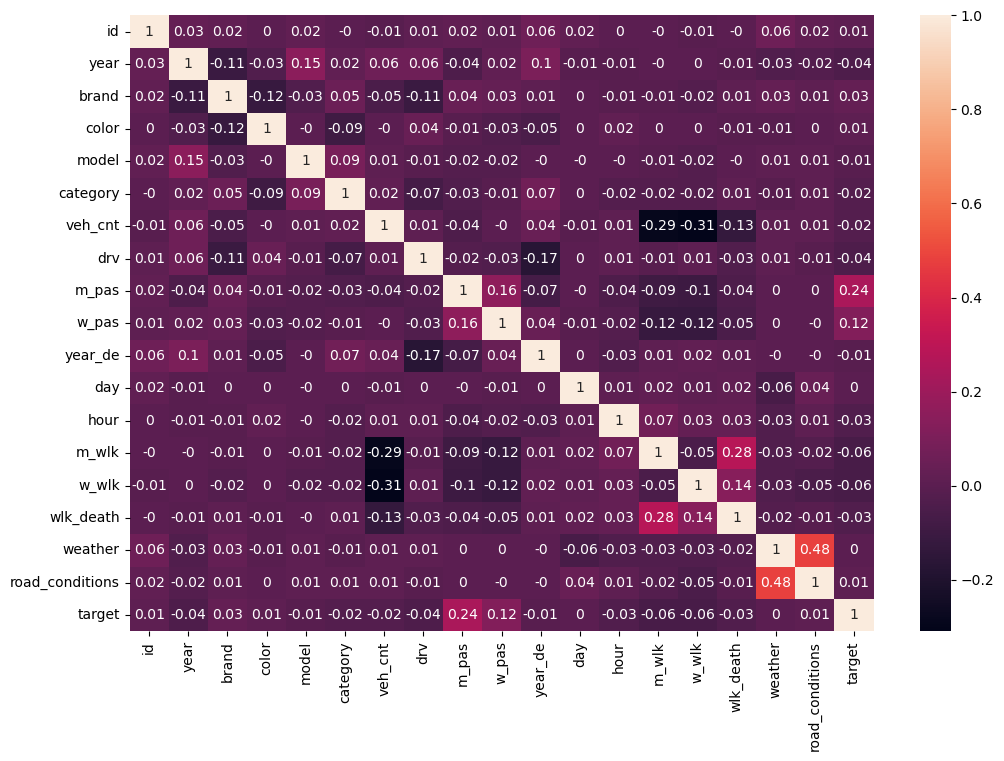

In [35]:
plt.figure(figsize = (12, 8))
sns.heatmap(data_test.corr().round(2), annot = True)
plt.show()

In [57]:
CONFIG_DIR = Path("../config/")
DATA_DIR = Path("../data/")

def get_creds(name):
    with CONFIG_DIR.joinpath("cfg_02_creds.json").open(encoding="utf-8") as data:
        return json.load(data).get(name)
    
creds = get_creds("hackathon_hst")
with psycopg2.connect(**creds) as conn:
    with conn.cursor() as cur:
        query = """select * 
                     from public.x_data_mod
                    where (m_pas = 1 or w_pas = 1) and (m_pas + w_pas = 1)
                """
        cur.execute(query)
        cols = [desc[0] for desc in cur.description]
        data_emulate = pd.DataFrame(cur.fetchall(), columns=cols)

data_emulate["id"] = data_emulate["id"].astype(int)
data_emulate["year"] = data_emulate["year"].astype(int)
data_emulate["brand"] = LabelEncoder().fit_transform(data_emulate["brand"]).astype(int)
data_emulate["color"] = LabelEncoder().fit_transform(data_emulate["color"]).astype(int)
data_emulate["model"] = LabelEncoder().fit_transform(data_emulate["model"]).astype(int)
data_emulate["category"] = LabelEncoder().fit_transform(data_emulate["category"]).astype(int)
data_emulate["veh_cnt"] = data_emulate["veh_cnt"].astype(int)
data_emulate["drv"] = LabelEncoder().fit_transform(data_emulate["drv"]).astype(int)
data_emulate["m_pas"] = data_emulate["m_pas"].astype(int)
data_emulate["w_pas"] = data_emulate["w_pas"].astype(int)
data_emulate["year_de"] = data_emulate["year_de"].astype(int)
data_emulate["day"] = data_emulate["day"].astype(int)
data_emulate["hour"] = data_emulate["hour"].astype(int)
data_emulate["m_wlk"] = data_emulate["m_wlk"].astype(int)
data_emulate["w_wlk"] = data_emulate["w_wlk"].astype(int)
data_emulate["wlk_death"] = data_emulate["wlk_death"].astype(int)
data_emulate["weather"] = LabelEncoder().fit_transform(data_emulate["weather"]).astype(int)
data_emulate["road_conditions"] = LabelEncoder().fit_transform(data_emulate["road_conditions"]).astype(int)
data_emulate["target"] = data_emulate["target"].astype(int)

x_emulate = data_emulate[["year", "brand", "color", "model", "category", "veh_cnt", "drv", "m_pas", "w_pas", "year_de", "day", "hour", "m_wlk", "w_wlk", "wlk_death", "weather", "road_conditions"]]
y_predict = rfc.predict(x_emulate)